# Home Task 1

### ~ Rene Salih

In [185]:
# Windows 10 used to write and test the code.
import re
import os
import numpy as np
import pandas as pd
from pathlib import Path # To ensure path compatibility with unix systems
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pyprind # Python Progress Indicator module provides a progress bar and a percentage indicator object that let you 
# track the progress of a loop structure or other iterative computation

# fixing random seed for reproducibility
np.random.seed(123)

In [186]:
basepath = r'C:\Users\Rene\OneDrive\MSc Data Analytics\Natural Language Processing\aclImdb\\' # replace to the path with the appropriate one

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
movie_reviews_df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
            movie_reviews_df = movie_reviews_df.append([[txt, labels[l]]], ignore_index=True) 
            pbar.update()

movie_reviews_df.columns = ["Review", "Sentiment"]

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:06:40


In [187]:
movie_reviews_df = movie_reviews_df.reindex(np.random.permutation(movie_reviews_df.index))
movie_reviews_df.to_csv('movie_data.csv', index=False, encoding='utf-8')

movie_reviews_df = pd.read_csv('movie_data.csv', encoding='utf-8')

pos_review_df = movie_reviews_df.loc[movie_reviews_df['Sentiment'] == 1]  # 25000
neg_review_df = movie_reviews_df.loc[movie_reviews_df['Sentiment'] == 0]  # 25000

# Split into 70%, 10% and 20% for training, validation and testing respectively
pos_review_tr, pos_review_dev, pos_review_ts = np.split(pos_review_df.sample(frac=1, random_state=42), 
                                                        [int(.7*len(pos_review_df)), int(.8*len(pos_review_df))])

neg_review_tr, neg_review_dev, neg_review_ts = np.split(neg_review_df.sample(frac=1, random_state=42), 
                                                        [int(.7*len(neg_review_df)), int(.8*len(neg_review_df))])

# Create train, dev and test sets of both positive and negative reviews
data_tr = pos_review_tr.append(neg_review_tr, ignore_index=True) # 35000
data_dev = pos_review_dev.append(neg_review_dev, ignore_index=True) # 2500
data_ts = pos_review_ts.append(neg_review_ts, ignore_index=True) # 5000

# Shuffle all the dataframes
data_tr = data_tr.sample(frac=1).reset_index(drop=True)
data_dev = data_dev.sample(frac=1).reset_index(drop=True)
data_ts = data_ts.sample(frac=1).reset_index(drop=True)

In [188]:
data_tr.head()

,Review,Sentiment
0,I really enjoyed this movie as a young kid. At...,1
1,I really love anything done by Savage Steve Ho...,1
2,"I'm not sure what version of the film I saw, b...",1
3,"jeez, when i heard this movie was a NATIONAL L...",0
4,I discovered this film after reading the book ...,1


### Load Raw texts and labels into arrays

In [189]:
labels_tr = data_tr["Sentiment"].to_numpy()
review_tr = data_tr["Review"].tolist()

labels_ts = data_ts["Sentiment"].to_numpy()
review_ts = data_ts["Review"].tolist()

labels_dev = data_dev["Sentiment"].to_numpy()
review_dev = data_dev["Review"].tolist()

### Bag-of-Words Representation 

### N-gram extraction from a document

In [190]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

In [191]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    
    tuples = []
    
    # remove all non-words from the string
    words = re.compile(token_pattern)
    words_extract = words.findall(x_raw)
    
    # set all words to lower case (this was implemented due to the second task having somewhat unprocessed text)
    words_extract = [x.lower() for x in words_extract]
    
    # remove all words that are stop words
    words_extract = [n for n in words_extract if n not in stop_words]
    
    # construct ngrams between ngram_range[0] and ngram_range[1]
    for i in range(ngram_range[0], ngram_range[1]+1):
        if(i < 2): continue
        
        # find n-grams of length i
        for n in range(len(words_extract)+1):
            
            # check theoretical tuple is valid ie n+i < len(x_raw) 
            if(n+i >= len(words_extract)+1): break

            # take slice of n:n+i and turn into tuple, add tuple to array for later concaternation
            tuples.append(tuple(words_extract[n:n+i]))

    words_extract +=  tuples
    
    # remove all words not in vocab unless  vocab is default then ignore vocab
    if (vocab != set()):
        words_extract = [n for n in words_extract if n in vocab]
            
    return words_extract

### Create a vocabulary of n-grams

In [192]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    
    vocab = set()
    ngram_counts = Counter()     # term frequencies
    df_counter = Counter()       # document frequencies

    # loop through each element in the array X_raw
    for i in range(len(X_raw)):

        # extract the ngrams from the text
        extracted_words = extract_ngrams(X_raw[i], ngram_range, token_pattern, stop_words)
        
        # update the df counter (transform to set to ensure you only count one of each word per doc)
        df_counter.update(set(extracted_words))
        
        # update the tf counter
        ngram_counts.update(extracted_words)
            
    # ensure that topN_cutoff is the highest threshold
    if (keep_topN < min_df):
        keep_topN = min_df
    
    # keep the top 'keep_topN' df's
    df_counter = Counter(dict(df_counter.most_common(keep_topN)))
     
    # keep the top 'keep_topN' tf's
    for word in list(ngram_counts):
        if word not in df_counter:
            del ngram_counts[word]
    
    # make a list of the vocabulary
    vocab, _ = map(set, zip(*df_counter.most_common(keep_topN)))
                              
    return vocab, df_counter, ngram_counts

In [193]:
vocab, df, ngram_counts = get_vocab(review_tr, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(df.most_common()[:10])

[('but', 24984), ('movie', 21370), ('not', 20806), ('br', 20445), (('br', 'br'), 20443), ('one', 19919), ('film', 19401), ('all', 18196), ('so', 16322), ('like', 16270)]


In [194]:
def corpus_to_ngram(X_raw, vocab, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b'):
    
    # Define the return object
    X_ngram = []
    
    # turns a list of documents into a list of documents turned into ngrams
    
    # loop through each element in the list X_raw
    for i in range(len(X_raw)):
        
        # extract the ngrams from the text
        extracted_words = extract_ngrams(X_raw[i], ngram_range, token_pattern, [], vocab)
        
        # append the ngrams to the list
        X_ngram.append(extracted_words)
    
    return X_ngram

In [195]:
tr_ngram = corpus_to_ngram(review_tr, vocab)
ts_ngram = corpus_to_ngram(review_ts, vocab)
dev_ngram = corpus_to_ngram(review_dev, vocab)

### Vectorise documents 

In [196]:
def vectorise(X_ngram, vocab, df = None):
    
    X_vec = np.zeros((len(X_ngram), len(vocab)))
    vocab = list(vocab)
    
    for i in range(len(X_ngram)):
        
        # a count fo each word in the document
        doc = Counter(X_ngram[i][:])
        
        for j in range(len(vocab)):

            if ((vocab[j] in X_ngram[i][:]) and df!= None ): 
                
                # Create tfidf count
                X_vec[i][j] = doc[vocab[j]] * np.log10(len(df) / df[vocab[j]])
                
            elif(vocab[j] in X_ngram[i][:]):
                
                # Create a normal count matrix
                X_vec[i][j] = doc[vocab[j]]
                
    return X_vec

In [197]:
tr_vec = vectorise(tr_ngram, vocab)
ts_vec = vectorise(ts_ngram, vocab)
dev_vec = vectorise(dev_ngram, vocab)

In [ ]:
tr_vec_tfidf = vectorise(tr_ngram, vocab, df)
ts_vec_tfidf = vectorise(ts_ngram, vocab, df)
dev_vec_tfidf = vectorise(dev_ngram, vocab, df)

### Binary Logistic Regression

In [199]:
def sigmoid(z):
    # This fn includes a replacement for very low values to avoid overflow errors
    if (isinstance(z, np.ndarray)):
        z[z < -600] = -600
    elif (z < -600): z = -600
    
    return 1/(1 + np.exp(-z))

In [200]:
def predict_proba(X, weights):

    return sigmoid(np.dot(X, weights))

weights = np.full(len(vocab), -1000)

predict_proba(tr_vec, weights)

array([2.65039655e-261, 2.65039655e-261, 2.65039655e-261, ...,
       2.65039655e-261, 2.65039655e-261, 2.65039655e-261])

In [201]:
def predict_class(X, weights):
    
    preds_class = predict_proba(X, weights)
    
    preds_class[preds_class >= 0.5] = 1
    preds_class[preds_class < 0.5] = 0
    
    return preds_class

predict_class(tr_vec, weights)

array([0., 0., 0., ..., 0., 0., 0.])

In [202]:
def binary_loss(X, Y, weights, alpha=0.00001):
    
    # using X and weights make an array of probability predictions
    Y_prob = predict_proba(X, weights)
    
    # regularisation
    reg = np.sum(np.square(weights))

    # compare predictions to Y and calculate L_vec for every Y
    l_vec = -Y * np.log(Y_prob) - (1 - Y) * np.log(1 - Y_prob) + alpha* reg
    
    return np.sum(l_vec)/ len(Y)

### Implement Stochastic Gradient Descent to learn the weights of your sentiment classifier

In [203]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    tr_loss_history = []
    val_loss_history = []
    
    # Initalise weights
    w = np.zeros(X_tr.shape[1])
    
    for i in range(epochs):
        
        # randomise the order in the data every epoch
        randomise = np.arange(len(Y_tr))
        np.random.shuffle(randomise)
        X_tr = X_tr[randomise]
        Y_tr = Y_tr[randomise]
        
        # Over the dataset modify the weights
        for j in range(len(Y_tr)):
            
            grad = (predict_proba(w, X_tr[j, :]) - Y_tr[j]) * X_tr[j, :] + 2 * alpha * w
            w -= lr * grad

        # Calculate the training and validation loss after each epoch
        tr_loss_history.append(binary_loss(X_tr, Y_tr, w, alpha))
        val_loss_history.append(binary_loss(X_dev, Y_dev, w, alpha))
        
        if(print_progress):
            print("Epoch: %3i|\t Training loss: %7f|\t Validation loss: %7f" 
                  % (i, tr_loss_history[i], val_loss_history[i]))
        
        # test to see if validation set is getting larger or the change is smaller than tolerance
        if((i > 0) and (i != epochs - 1) and ((val_loss_history[i-1] - val_loss_history[i]) < tolerance)):
            break
        
    return w, tr_loss_history, val_loss_history

In [155]:
def hyper_param_learning(fn_SGD ,tr_vec, tr_labels, dev_vec, dev_labels, 
                         lr = (0.0001, 0.001), 
                         alpha = (0.001, 0.0001), 
                         n_tested = 10,
                         print_progress = True):
    
    # This is a grid method that calculates the loss for each combination of parameter,
    # it will test n_tested * n_tested number of combinations.
    # But this is very slow and will not be run  in the notebook to demonstrate
    # it works.
      
    # The different values of the parameters to be tested
    lr_vars =  np.linspace(lr[0], lr[1], n_tested)
    alpha_vars = np.linspace(alpha[0], alpha[1], n_tested)
    
    # initialise arrays to store the losses
    best_tr_loss = best_dev_loss = tmp_dev = tmp_tr = []
    
    # Best Hyper Param Positions
    best_alpha = best_lr = 0
    
    # initilise arrays to store the weights
    best_w = temp_w = np.zeros(tr_vec.shape[1])
    
    # test all variations of the parameters
    for i in range(n_tested):
        for j in range(n_tested):
            
            temp_w, tmp_tr, tmp_dev = fn_SGD(tr_vec, tr_labels, 
                                             dev_vec, 
                                             dev_labels, 
                                             lr= lr_vars[i], 
                                             alpha= alpha_vars[j], 
                                             epochs=200,
                                             print_progress=False)
            if(print_progress):
                print("Alpha: %7f|\t Lr: %7f|\t Epoch: %3i|\t Val loss: %7f|" 
                      % (alpha_vars[j], lr_vars[i], len(tmp_dev), tmp_dev[-1]))
            
            # test if we have the first variation tested and then if we have the best
            if(i==j==0):
                best_tr_loss = tmp_tr
                best_dev_loss = tmp_dev
                best_w = temp_w 
                continue
            elif(tmp_dev[-1] < best_dev_loss[-1]):
                print("New Best Found")
                best_tr_loss = tmp_tr
                best_dev_loss = tmp_dev
                best_w = temp_w
                best_alpha = j
                best_lr = i 
    
    # Print the best results
    if(print_progress):
        print("-" * 30)
        print("Best Alpha: ", alpha_vars[best_alpha])
        print("Best Lr: ", lr_vars[best_lr])
        print("Lowest Loss: ", best_dev_loss[-1])
        print("-" * 30)
        
    # return the best w, training loss and dev loss
    return best_w, best_tr_loss, best_dev_loss

### Train and Evaluate Logistic Regression with Count vectors

In [204]:
w_count, loss_tr_count, dev_loss_count = SGD(tr_vec, labels_tr, 
                                             dev_vec, 
                                             labels_dev, 
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=200)

Epoch:   0|	 Training loss: 0.522178|	 Validation loss: 0.529536
Epoch:   1|	 Training loss: 0.469912|	 Validation loss: 0.479322
Epoch:   2|	 Training loss: 0.440400|	 Validation loss: 0.450145
Epoch:   3|	 Training loss: 0.421293|	 Validation loss: 0.432706
Epoch:   4|	 Training loss: 0.406658|	 Validation loss: 0.418200
Epoch:   5|	 Training loss: 0.396040|	 Validation loss: 0.408006
Epoch:   6|	 Training loss: 0.386995|	 Validation loss: 0.399686
Epoch:   7|	 Training loss: 0.378429|	 Validation loss: 0.392942
Epoch:   8|	 Training loss: 0.371822|	 Validation loss: 0.387209
Epoch:   9|	 Training loss: 0.366325|	 Validation loss: 0.381843
Epoch:  10|	 Training loss: 0.361116|	 Validation loss: 0.377940
Epoch:  11|	 Training loss: 0.356810|	 Validation loss: 0.374768
Epoch:  12|	 Training loss: 0.353149|	 Validation loss: 0.372155
Epoch:  13|	 Training loss: 0.349259|	 Validation loss: 0.368555
Epoch:  14|	 Training loss: 0.345883|	 Validation loss: 0.365103
Epoch:  15|	 Training los

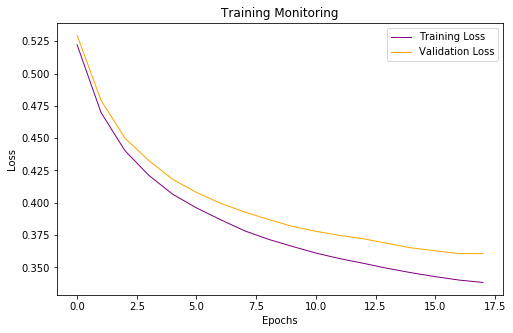

In [205]:
def plot_training_loss(training_loss, validation_loss):
    
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(len(training_loss)), training_loss, color='purple', linewidth=1.0, linestyle='-')
    plt.plot(np.arange(len(validation_loss)), validation_loss, color='orange', linewidth=1.0, linestyle='-')
    plt.legend(('Training Loss', 'Validation Loss'))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Monitoring")
    plt.show()

plot_training_loss(loss_tr_count, dev_loss_count)

In [206]:
def accuracy_score_s(Y_te,preds_te_count):

    true_pos  = np.sum(np.logical_and(label_predict == 1, labels_ts == 1))
    true_neg  = np.sum(np.logical_and(label_predict == 0, labels_ts == 0))
    
    accuracy = (true_pos + true_neg)/ len(labels_ts)
    
    return accuracy

def precision_score_s(Y_te,preds_te_count):

    true_pos  = np.sum(np.logical_and(label_predict == 1, labels_ts == 1))
    false_pos = np.sum(np.logical_and(label_predict == 1, labels_ts == 0))
    
    precision = true_pos/(true_pos + false_pos)
    
    return precision

def recall_score_s(Y_te,preds_te_count):

    true_pos  = np.sum(np.logical_and(label_predict == 1, labels_ts == 1))
    false_neg = np.sum(np.logical_and(label_predict == 0, labels_ts == 1))
    
    recall = true_pos/(true_pos + false_neg)
    
    return recall

def f1_score_s(Y_te,preds_te_count):
    
    true_pos  = np.sum(np.logical_and(label_predict == 1, labels_ts == 1))
    true_neg  = np.sum(np.logical_and(label_predict == 0, labels_ts == 0))
    false_pos = np.sum(np.logical_and(label_predict == 1, labels_ts == 0))
    false_neg = np.sum(np.logical_and(label_predict == 0, labels_ts == 1))
    
    accuracy = (true_pos + true_neg)/ len(labels_ts)
    precision = true_pos/(true_pos + false_pos)
    recall = true_pos/(true_pos + false_neg)
    f1_score = (2* precision * recall) / (precision + recall)
    
    return f1_score

label_predict = predict_class(ts_vec, w_count)

print('Accuracy: %.3f' % (accuracy_score_s(labels_ts, label_predict)))
print('Precision: %.3f' % (precision_score_s(labels_ts, label_predict)))
print('Recall: %.3f' % (recall_score_s(labels_ts, label_predict)))
print('F1-Score: %.3f' % (f1_score_s(labels_ts, label_predict)))

Accuracy: 0.873
Precision: 0.874
Recall: 0.871
F1-Score: 0.872


In [207]:
def print_top_words(vocab, w, num_printed = 10, positive = True):
            
    if(positive):
        w = -w
    
    result_positions = np.argpartition(w, num_printed)[:num_printed]
    
    for i in range(num_printed):
        print(list(vocab)[result_positions[i]])

In [208]:
print_top_words(vocab, w_count, positive = True)

excellent
best
wonderful
great
perfect
amazing
fun
loved
brilliant
love


In [209]:
print_top_words(vocab, w_count, positive = False)

waste
worst
bad
boring
awful
terrible
nothing
poor
stupid
worse


In [ ]:
w_tfidf_m, loss_tr_tfidf_m, dev_loss_tfidf_m = SGD_m(tr_vec_tfidf_multi, labels_tr_multi, 
                                             X_dev=dev_vec_tfidf_multi, 
                                             Y_dev=labels_dev_multi,
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=200)

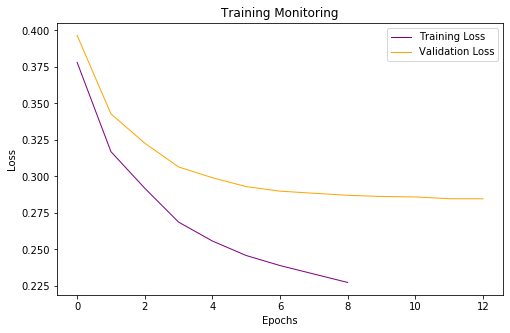

In [210]:
plot_training_loss(trl, devl)

In [211]:
label_predict = predict_class(ts_vec_tfidf, w_tfidf)

print('Accuracy: %.3f' % (accuracy_score(labels_ts, label_predict)))
print('Precision: %.3f' % (precision_score(labels_ts, label_predict)))
print('Recall: %.3f' % (recall_score(labels_ts, label_predict)))
print('F1-Score: %.3f' % (f1_score(labels_ts, label_predict)))

Accuracy: 0.495
Precision: 0.496
Recall: 0.505
F1-Score: 0.500


In [90]:
print_top_words(vocab, w_tfidf, positive = True)

hilarious
excellent
wonderful
bad
perfect
superb
brilliant
amazing
loved
fantastic


In [91]:
print_top_words(vocab, w_tfidf, positive = False)

horrible
terrible
worst
poor
best
poorly
awful
waste
boring
great
